<a href="https://colab.research.google.com/github/guilimadev/Volleyball-Game-Win-Predictor/blob/main/Volleyball_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
import warnings

warnings.filterwarnings("ignore")

In [54]:
df_vnl = pd.read_csv('gdrive/My Drive/Colab Notebooks/csv/vnl_2021_preliminaryround_mens.csv',index_col=1)
df_vnl = df_vnl.drop('Unnamed: 0', axis=1)

df_pallavolo = pd.read_csv('gdrive/My Drive/Colab Notebooks/csv/Pallavolo_Teams_Stats.csv')
df_pallavolo = df_pallavolo.drop('Unnamed: 0', axis=1)

In [25]:
df_vnl.index.names = ['id_jogo']


In [26]:
df_vnl = df_vnl.rename(columns={'qts sets': 'qtd sets'})
df_vnl.head()

,team home,total atq home,pontos ataques home,atq error home,% atq home,% rec home,bloqueio home,server error home,team away,total atq away,pontos ataques away,atq error away,% atq away,% rec away,bloqueio away,server error away,qtd sets,vencedor
id_jogo,,,,,,,,,,,,,,,,,,
11700,France,77,39,8,51,44,7,19,Bulgaria,76,36,15,47,39,5,17,3,True
11701,Germany,70,42,6,60,35,5,19,Australia,61,28,9,46,25,3,15,3,True
11702,Japan,94,45,13,48,50,7,7,Iran,84,41,12,49,46,8,16,3,True
11703,Serbia,121,66,19,55,33,14,19,Slovenia,111,53,21,48,30,9,17,4,True
11704,Netherlands,89,49,14,55,20,6,18,Russia,94,51,11,54,29,10,18,4,False


In [27]:
df_sla = pd.read_csv('gdrive/My Drive/Colab Notebooks/csv/Superliga_2021.csv', index_col=0)
df_sla.head()


,team home,total atq home,pontos ataques home,atq error home,% atq home,% rec home,bloqueio home,server error home,team away,total atq away,pontos ataques away,atq error away,% atq away,% rec away,bloqueio away,server error away,qtd sets,vencedor
id_jogo,,,,,,,,,,,,,,,,,,
1239,MONTES CLAROS AMERICA VOLEI,102,41,9,40,59,14,14,BRASILIA VÔLEI,101,39,13,39,76,14,16,4,True
1240,VOLEI FUNVIC NATAL,59,33,6,56,59,11,13,GOIÁS VÔLEI,61,18,13,30,48,6,8,3,True
1241,VOLEI RENATA,123,57,11,46,64,15,21,SESI-SP,138,58,12,42,66,13,18,5,False
1242,VEDACIT VÔLEI GUARULHOS,102,54,16,53,53,7,17,FIAT/GERDAU/MINAS,103,54,10,52,59,7,14,4,False
1243,SADA CRUZEIRO,76,42,5,55,52,5,12,FARMA CONDE VÔLEI - SÃO JOSÉ,82,39,7,48,49,4,13,3,True


In [28]:
df_merged = pd.concat([df_vnl, df_sla])


In [29]:
df_merged['qtd sets'].describe

<bound method NDFrame.describe of id_jogo
11700    3
11701    3
11702    3
11703    4
11704    4
        ..
1305     3
1306     4
1307     3
1308     3
1309     3
Name: qtd sets, Length: 185, dtype: int64>

In [30]:
df_merged.shape

(185, 18)

In [31]:
df_merged['total atq home'] = df_merged['total atq home'] / df_merged['qtd sets']
df_merged['pontos ataques home'] = df_merged['pontos ataques home'] / df_merged['qtd sets']
df_merged['atq error home'] = df_merged['atq error home'] / df_merged['qtd sets']
df_merged['bloqueio home'] = df_merged['bloqueio home'] / df_merged['qtd sets']
df_merged['server error home'] = df_merged['server error home'] / df_merged['qtd sets']
df_merged['total atq away'] = df_merged['total atq away'] / df_merged['qtd sets']
df_merged['pontos ataques away'] = df_merged['pontos ataques away'] / df_merged['qtd sets']
df_merged['atq error away'] = df_merged['atq error away'] / df_merged['qtd sets']
df_merged['bloqueio away'] = df_merged['bloqueio away'] / df_merged['qtd sets']
df_merged['server error away'] = df_merged['server error away'] / df_merged['qtd sets']

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn import metrics
X = df_merged.drop(columns=['team home', 'team away', 'vencedor', 'qtd sets'])
y = df_merged['vencedor']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = RandomForestClassifier(min_samples_leaf=5, min_samples_split=2,n_estimators=100)
model.fit(X_train, y_train)
estimator = model.estimators_[5]


y_pred = model.predict(X_test)

scores = cross_val_score(model, X, y, cv=2)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Score: " , scores.mean())


Accuracy: 0.8928571428571429
Score:  0.84315100514259


In [33]:
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X.columns,                
                rounded = True, proportion = False, 
                precision = 2, filled = True)

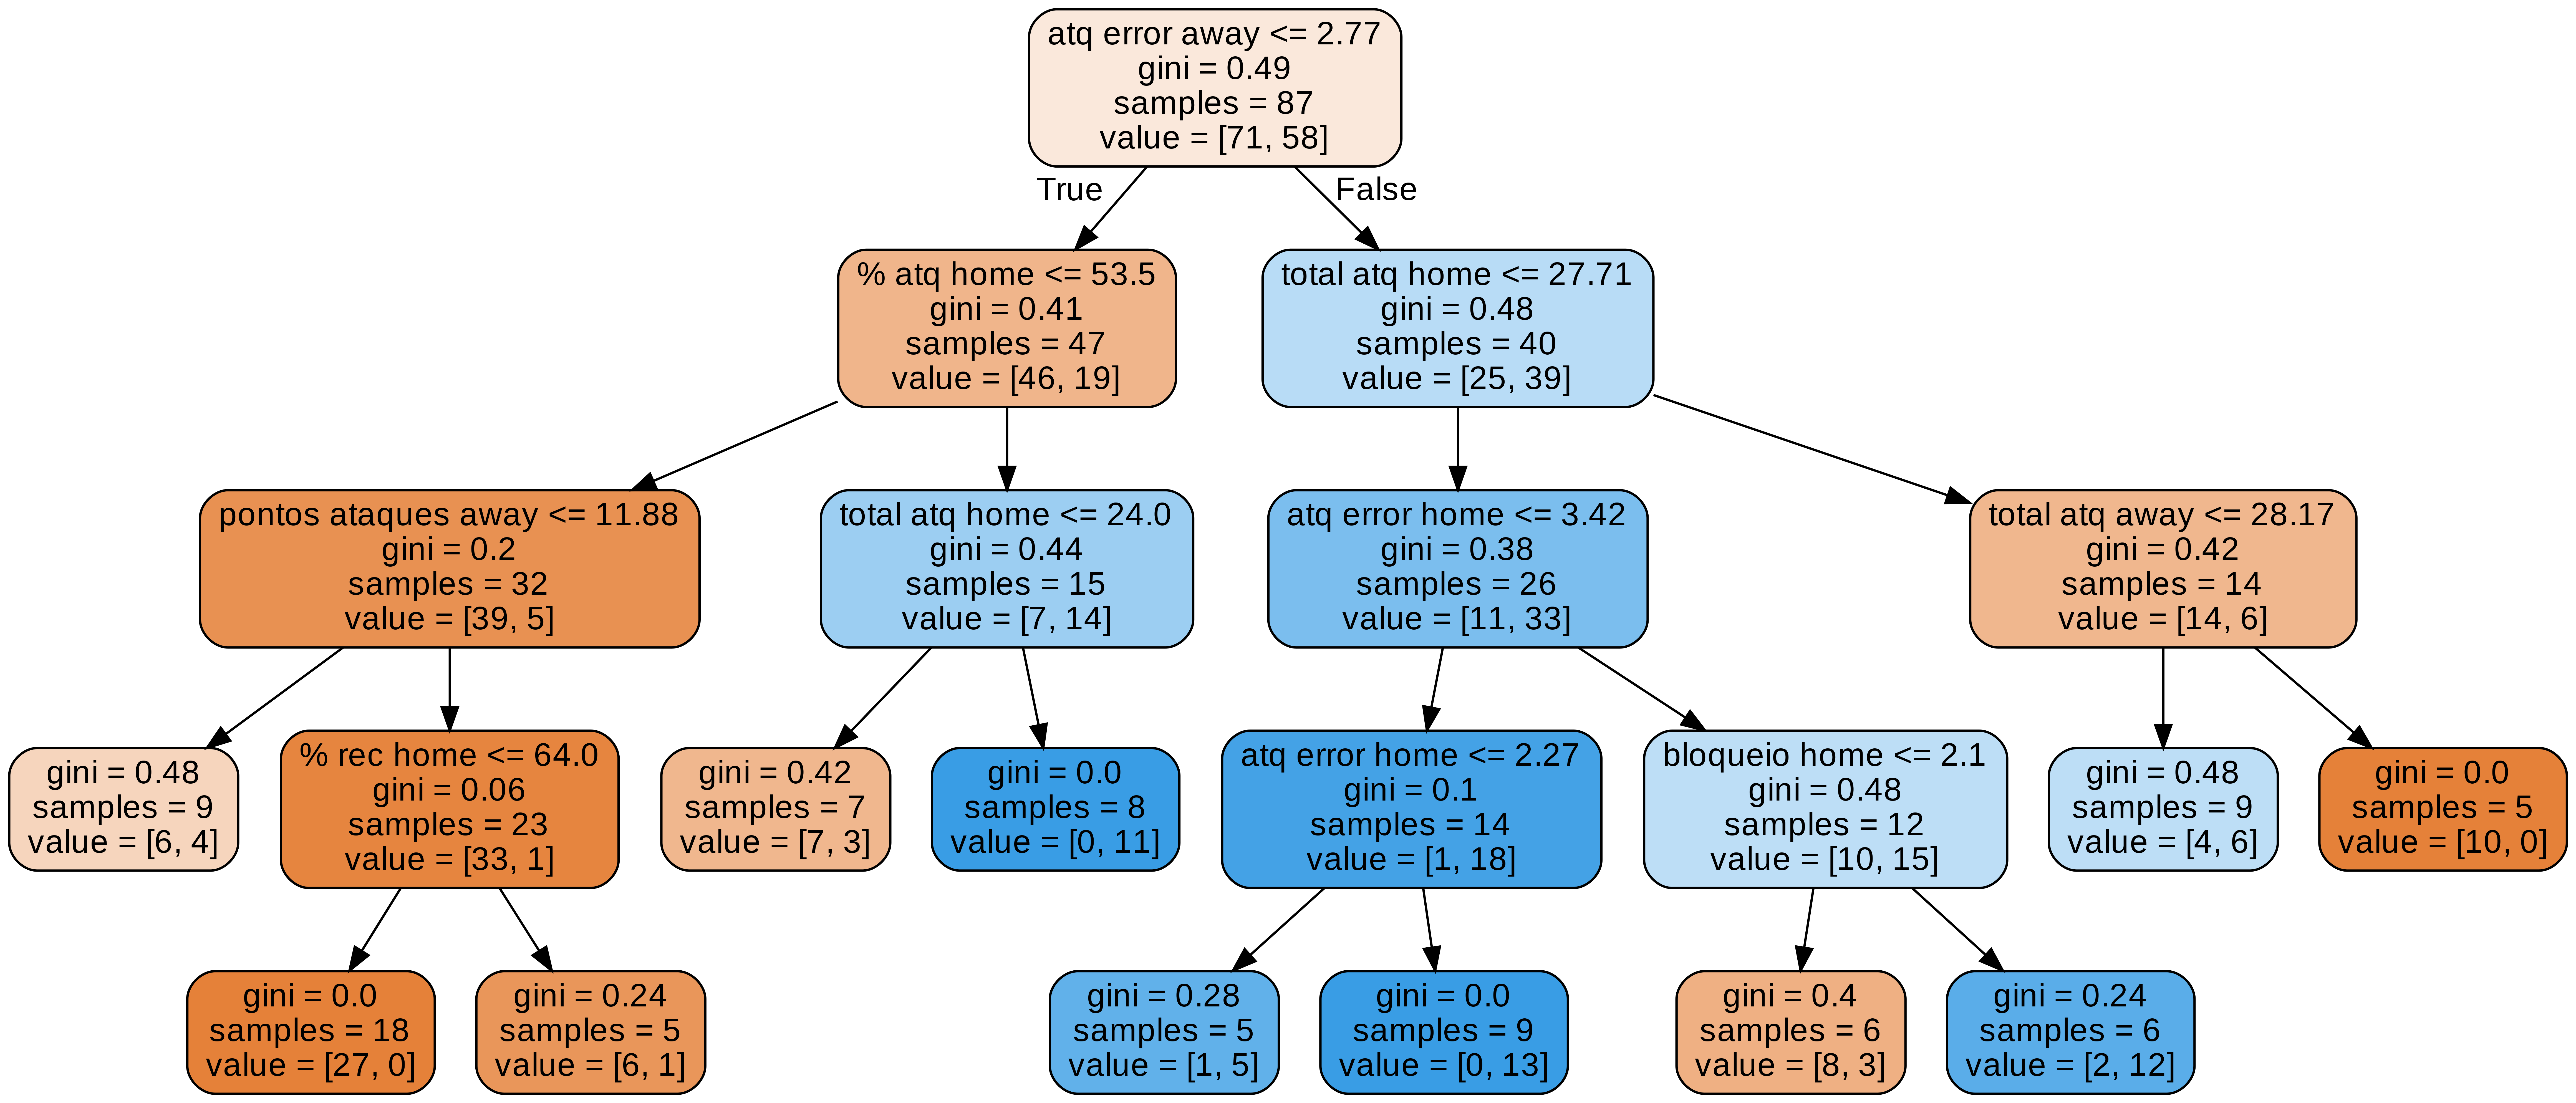

In [34]:
from subprocess import call
from IPython.display import Image
call(['dot','-Tpng','tree.dot','-o','tree.png','-Gdpi=600'])
Image(filename='tree.png')

In [36]:
df_merged.head()
df_splitted_away = df_merged[['team away','total atq away','pontos ataques away','atq error away','% atq away','% rec away','bloqueio away','server error away']]
cols = ['team', 'total atq', 'pontos ataque', 'atq error', '% atq', '% rec', 'bloqueio', 'server error']
df_splitted_away.columns = cols
df_splitted2 = df_merged[['team home','total atq home','pontos ataques home','atq error home','% atq home','% rec home','bloqueio home','server error home']]
df_splitted2.columns = cols
df_splitted2.tail()

,team,total atq,pontos ataque,atq error,% atq,% rec,bloqueio,server error
id_jogo,,,,,,,,
1305,GOIÁS VÔLEI,19.000000,11.666667,1.666667,61,46,3.666667,3.666667
1306,BRASILIA VÔLEI,23.000000,10.500000,3.250000,46,58,1.750000,6.000000
1307,FIAT/GERDAU/MINAS,25.000000,14.333333,1.333333,57,53,2.666667,6.333333
1308,VOLEI FUNVIC NATAL,28.000000,14.000000,2.333333,50,74,2.000000,5.666667
1309,SADA CRUZEIRO,26.333333,14.333333,2.000000,54,51,1.000000,6.000000


In [38]:
df_splitted_away.shape

(185, 8)

In [39]:
teams = df_splitted_away.team.unique()

In [40]:
import ipywidgets as widgets
from ipywidgets import interact

a = widgets.Dropdown(
    options=teams,  
    description='Home:',
    disabled=False,
)

b = widgets.Dropdown(
    options=teams,    
    description='Away:',
    disabled=False,
)



In [41]:
def resultPredict(a,b):
  home = df_splitted2.loc[df_splitted2['team'] == a]
  away = df_splitted_away.loc[df_splitted_away['team'] == b]

  home_medias = [round(home['total atq'].mean()),round(home['pontos ataque'].mean()),round(home['atq error'].mean()),round(home['% atq'].mean()),round(home['% rec'].mean()),round(home['bloqueio'].mean()),round(home['server error'].mean())]
  away_medias = [round(away['total atq'].mean()),round(away['pontos ataque'].mean()),round(away['atq error'].mean()),round(away['% atq'].mean()),round(away['% rec'].mean()),round(away['bloqueio'].mean()),round(away['server error'].mean())]
  
  resultado =  home_medias + away_medias
  resultado_final = np.array(resultado)

  resultado_chance = model.predict_proba(resultado_final.reshape(1,-1))
  resultado_home_porcetagem = round(resultado_chance[0][1] * 100, 2)
  resultado_away_porcetagem =  round(resultado_chance[0][0] * 100, 2)
  print('Chances do time',home['team'].iloc[0] ,'vencer:',str(resultado_home_porcetagem)+'%\n'+'Chances do time',away['team'].iloc[0] ,'vencer:',str(resultado_away_porcetagem)+'%')

In [42]:
interact(resultPredict,a=teams,b=teams)

interactive(children=(Dropdown(description='a', options=('Bulgaria', 'Australia', 'Iran', 'Slovenia', 'Russia'…

<function __main__.resultPredict>

In [44]:
pallavolo_teams = df_pallavolo.team.unique()

In [43]:
c = widgets.Dropdown(
    options=pallavolo_teams,  
    description='Home:',
    disabled=False,
)

d = widgets.Dropdown(
    options=pallavolo_teams,    
    description='Away:',
    disabled=False,
)

In [63]:
def resultPredictPalla(c,d):
  home = df_pallavolo.loc[df_pallavolo['team'] == c]
  away = df_pallavolo.loc[df_pallavolo['team'] == d]

  home_medias = [round(home['total atq'].mean()),round(home['pontos ataque'].mean()),round(home['atq error'].mean()),round(home['% atq'].mean()),round(home['% rec'].mean()),round(home['bloqueio'].mean()),round(home['server error'].mean())]
  away_medias = [round(away['total atq'].mean()),round(away['pontos ataque'].mean()),round(away['atq error'].mean()),round(away['% atq'].mean()),round(away['% rec'].mean()),round(away['bloqueio'].mean()),round(away['server error'].mean())]
  
  resultado =  home_medias + away_medias
  resultado_final = np.array(resultado)

  resultado_chance = model.predict_proba(resultado_final.reshape(1,-1))
  resultado_home_porcetagem = round(resultado_chance[0][1] * 100, 2)
  resultado_away_porcetagem =  round(resultado_chance[0][0] * 100, 2)
  print('Chances do time',home['team'].iloc[0] ,'vencer:',str(resultado_home_porcetagem)+'%\n'+'Chances do time',away['team'].iloc[0] ,'vencer:',str(resultado_away_porcetagem)+'%')

In [66]:
df_pallavolo['bloqueio'] = df_pallavolo['bloqueio'].str.replace(',','.')
df_pallavolo

,team,total atq,pontos ataque,atq error,% atq,% rec,bloqueio,server error
0,Monza Vero Volley,24.573770,12.21,1.87,49.70,55.66,2.15,4.28
1,PiacenzaYou,26.157895,12.63,2.11,48.29,57.84,2.11,4.46
2,Modena,25.946429,13.25,1.66,51.07,54.23,2.20,3.89
3,Latina,26.589286,12.54,2.23,47.15,51.30,2.39,3.36
4,Verona,25.800000,12.25,1.62,47.50,51.18,2.25,3.69
5,Milano Power,26.872727,12.35,1.67,45.94,56.30,2.49,4.20
6,Perugia,24.690909,12.89,1.38,52.21,57.68,2.67,4.60
7,Trento,25.415094,12.96,1.58,51.00,57.07,2.62,3.45
8,Padova,25.157895,11.30,2.26,44.91,51.45,1.77,5.37
9,Taranto,28.060000,12.72,2.14,45.33,62.78,1.94,3.70


In [67]:
interact(resultPredictPalla,c=pallavolo_teams,d=pallavolo_teams)

interactive(children=(Dropdown(description='c', options=('Monza Vero Volley', 'PiacenzaYou', 'Modena', 'Latina…

<function __main__.resultPredictPalla>